# YOLO for Object Tracking
## Tracking Traffic Signs and Traffic Lights
The main goal of this project is to create a model capable of **detecting** and also **tracking** traffic signs and traffic lights.

### Dependency
Before starting with this notebook, It is important to install the correct dependencies for this project. We will start by downloading the roboflow library for installing our datasets and we will also install ultralytics for importing and use YOLO.

### YOLO
The YOLO network is highly efficient for object detection tasks. However, we will also need to incorporate other computer vision algorithms to adapt object detection for object tracking.

In [2]:
!pip install roboflow
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 905.3/905.3 kB 35.1 MB/s eta 0:00:00


### Dataset
First and foremost, it is essential to download the dataset that will be used for training the YOLOv11 architecture. Additionally, we will download a series of videos from another dataset to check and test whether our architecture functions correctly.

In [3]:
import kagglehub
from roboflow import Roboflow

traffic_lights_video_path = kagglehub.dataset_download('matteoiorio/traffic-lights-video')

rf = Roboflow(api_key="Ex8Yj8EiaKSeCDoNeUms")
project = rf.workspace("ithb-5ka4m").project("lisa-traffic-light-detection-8vuch")
version = project.version(3)
traffic_lights = version.download("yolov11")

project = rf.workspace("usmanchaudhry622-gmail-com").project("traffic-and-road-signs")
version = project.version(1)
traffic_signs = version.download("yolov11")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to LISA-traffic-light-detection-3 in yolov11:: 100%|██████████| 17882/17882 [00:01<00:00, 9577.19it/s] 

loading Roboflow workspace...


loading Roboflow project...



Extracting Dataset Version Zip to Traffic-and-Road-Signs-1 in yolov11:: 100%|██████████| 20012/20012 [00:01<00:00, 10294.95it/s]


In [5]:
print(traffic_lights.location)
print(traffic_signs.location)

/kaggle/working/LISA-traffic-light-detection-3
/kaggle/working/Traffic-and-Road-Signs-1


#### COLAB Utility
Add utility function for avoiding the colab disconnection during the YOLO training of the network. This function click every 60000 milliseconds to the connect button, in this way we can avoid to be disconnected.

In [4]:
# Ensure colab doesn't disconnect
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

### Dependencies
Before starting with this notebook, It is necessary to import all the different dependencies that will be used for training the network and use the trained network for tracking the different traffic signs and traffic lights.

In [6]:
# Import Essential Libraries
import os
import random
import cv2
from ultralytics import YOLO
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pathlib
from IPython.display import HTML
from base64 import b64encode
import warnings
warnings.filterwarnings('ignore')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Strategy
The problem encountered for this project is that, there was not a good dataset with both informations about traffic lights and also traffic signs. If we want to use DNN we need datasets with a lot of images, in order to have an high accuracy. So our idea is to use two different YOLO models, one will be trained only on traffic signs and another one on traffic lights, in this ways It will be possible to use two different specialized models for two different tasks, and by combining them It would be possible to accomplish our final task. Both dataset are formatted using the YOLO format, in this way training the system will much smoother. The ideal goal will be to have a single model capable of doing both tasks, but in order to do that we need a dataset resulting for example from the intersection of both datasets, in this way It is possible to have one single model capable of doing both tasks. But if we do so the training time will increase.

### Traffic Signs Dataset
The traffic signs dataset, that can be accessed at this link: https://universe.roboflow.com/usmanchaudhry622-gmail-com/traffic-and-road-signs, has 29 different classes and It is a subset of the GSTBR. Our first idea was to use the entire GSTBR dataset, but because of Its dimension and because we do not have the resources to train a model on such dataset, we decided to switch and use a subset of It. The original GSTBR dataset has more than 50 000 images. This dataset has exactly 10 000 different images of traffic signs, but also by having this kind of dimension It is really difficult to train the model in a short time period.

#### Traffic Signs Classes
This dataset contains 29 different classes, which are:
- Road narrows on right
- 50 KMPh speed limit
- Attention Please
- Beware of children
- CYCLE ROUTE AHEAD WARNING
- Dangerous Left Curve Ahead
- Dangerous Right Curve Ahead
- End of all speed and passing limits
- Give Way
- Go Straight or Turn Right
- Go straight or turn left
- Keep-Left
- Keep-Right
- Left Zig Zag Traffic
- No Entry
- No Over Taking
- Overtaking by trucks is prohibited
- Pedestrian Crossing
- Round-About
- Slippery Road Ahead
- Speed Limit 20 KMPh
- Speed Limit 30 KMPh
- Stop Sign
- Straight Ahead Only
- Traffic signal
- Truck traffic is prohibited
- Turn left ahead
- Turn right ahead
- Uneven Road

---
### Traffic Lights Dataset
The second dataset that we used is the Lisa traffic lights dataset, It has more than 9000 images of traffic lights. Even this dataset is a subset of the origial Lisa traffic Light dataset (https://www.kaggle.com/datasets/mbornoe/lisa-traffic-light-dataset) because the original one has more than 100K images. The dataset can be accessed using this link: https://universe.roboflow.com/ithb-5ka4m/lisa-traffic-light-detection-8vuch.


#### Traffic Lights Classes
1. go
2. stop
3. warning

In [7]:
def show_train_images(directory):
    num_samples = 9
    images_path = os.path.join(directory, "images")
    labels_path = os.path.join(directory, "labels")

    image_files = os.listdir(images_path)
    labels_files = {os.path.splitext(file)[0]: file for file in os.listdir(labels_path)}

    # Randomly select num_samples images
    rand_images = random.sample(image_files, num_samples)

    fig, axes = plt.subplots(3, 3, figsize=(11, 11))

    for i in range(num_samples):
        image = rand_images[i]
        image_name = os.path.splitext(image)[0]
        image_path = os.path.join(images_path, image)
        label_file = labels_files.get(image_name, None)

        # Load image
        img = plt.imread(image_path)

        ax = axes[i // 3, i % 3]
        ax.imshow(img)
        ax.axis('off')

        # Overlay labels if they exist
        if label_file:
            label_path = os.path.join(labels_path, label_file)
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    class_id = int(parts[0])
                    x_center, y_center, width, height = map(float, parts[1:])

                    # Convert YOLO format to rectangle coordinates
                    img_h, img_w = img.shape[:2]
                    x1 = int((x_center - width / 2) * img_w)
                    y1 = int((y_center - height / 2) * img_h)
                    x2 = int((x_center + width / 2) * img_w)
                    y2 = int((y_center + height / 2) * img_h)

                    # Draw rectangle and label
                    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='red', facecolor='none')
                    ax.add_patch(rect)
                    ax.text(x1, y1 - 10, f"Class: {class_id}", color='red', fontsize=8, backgroundcolor='white')

    plt.tight_layout()
    plt.show()


### Training Images
Here below will be listed some of the images that are taken from both of the two datasets. As we can see the two different datasets has completely different classes, by doing this our models will be specialized for two different tasks. The first dataset contains only road sign images, instead the second dataset only contains traffic lights images.

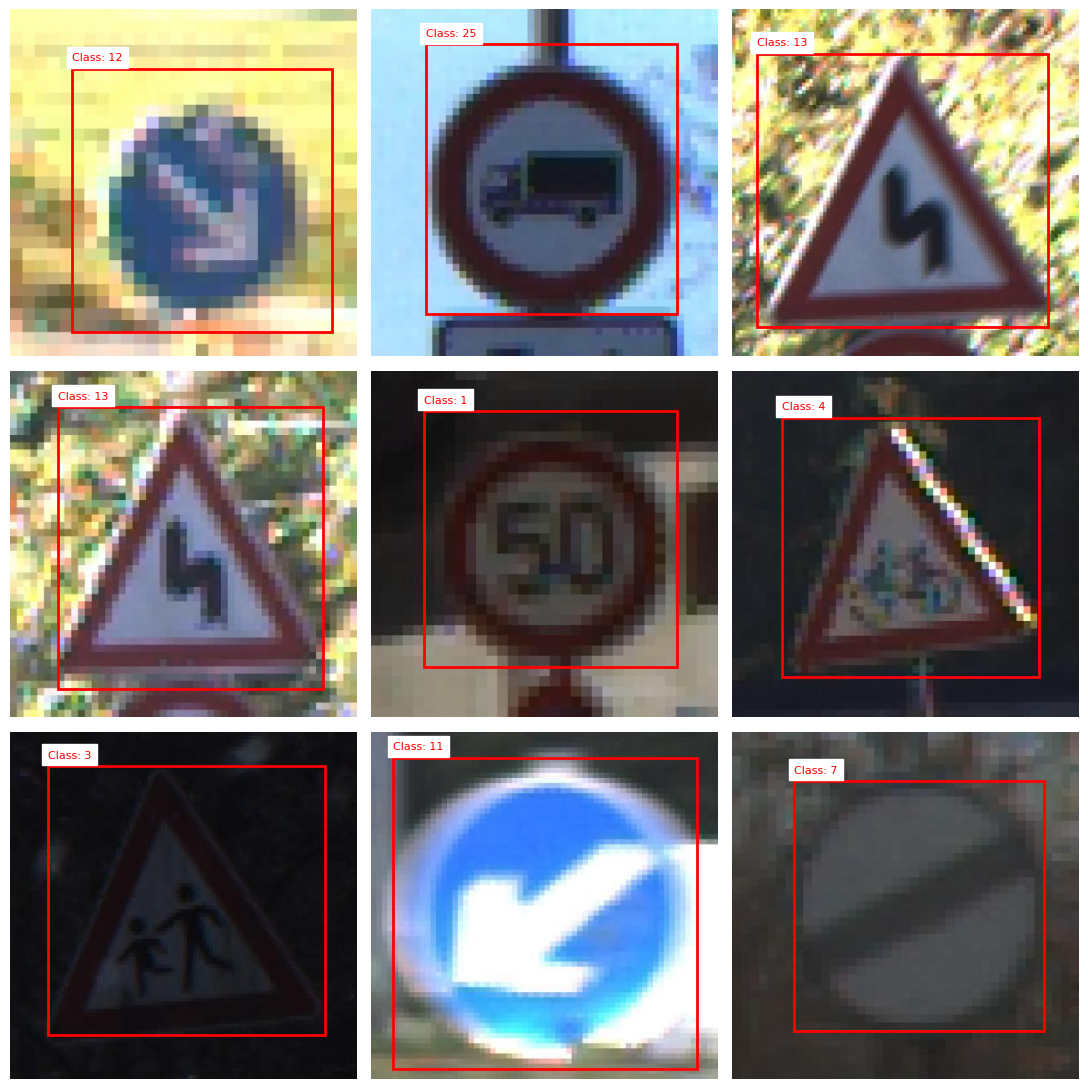

In [8]:
traffic_signs_images_dir = os.path.join(traffic_signs.location, "train")
traffic_lights_images_dir = os.path.join(traffic_lights.location, "train")
show_train_images(traffic_signs_images_dir)

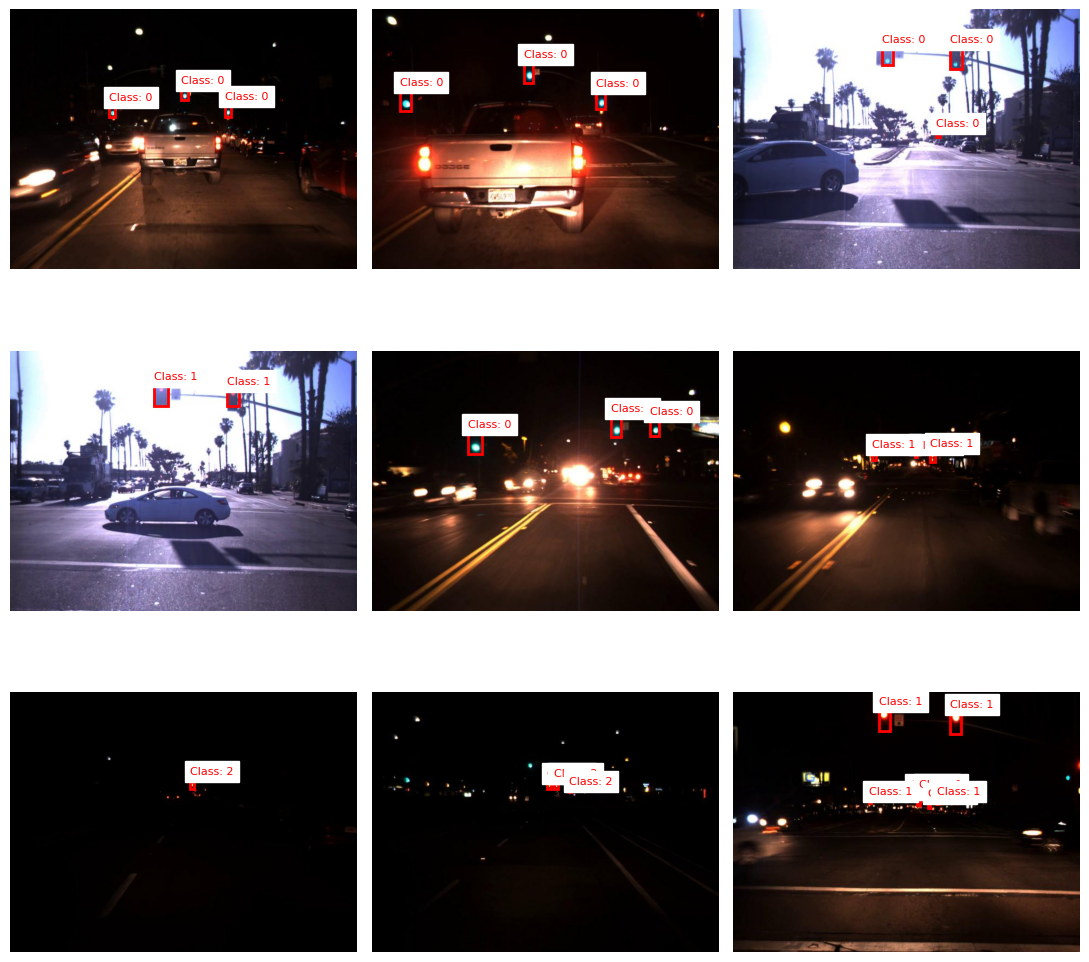

In [9]:
show_train_images(traffic_lights_images_dir)

### Validation Utils
To evaluate how effectively our models are performing, it's essential to review key validation metrics, including:

1. Confusion Matrix
2. F1 Score
3. Precision Curve
4. Recall Curve
5. Precision-Recall Curve

After completing YOLO's training, all this information is automatically saved in the base directory: /runs/detect. To analyze these metrics, we retrieve the latest training directory from the base path and visualize the stored data. This process provides valuable insights into the model's performance.

In [14]:
def get_latest_train_dir(base_path='./runs/detect'):
    # List all subdirectories in the base path
    subdirs = [os.path.join(base_path, d) for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
    # Sort subdirectories by creation time
    latest_dir = max(subdirs, key=os.path.getctime) if subdirs else None
    return latest_dir

def display_images(train_summary_path):
    image_files = [
        'confusion_matrix_normalized.png',
        'F1_curve.png',
        'P_curve.png',
        'R_curve.png',
        'PR_curve.png',
        'results.png'
    ]
    for image_file in image_files:
        image_path = os.path.join(train_summary_path, image_file)
        if not os.path.exists(image_path):
            print(f"Image not found: {image_path}")
            continue
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(10, 10), dpi=120)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

### YOLOv11 import and training
We trained the YOLOv11 model instand of YOLOv8 model because we needed a small model capable of performing this task with higher accuracy. Both of models will be trained for 30 epochs by using the default optimizer: Adam and using an automatic batch.

#### Traffic Signs Model
The first model that will be trained is the traffic sign model. This model will use the traffic signs dataset. Because also this dataset is very huge in dimension, the training will require a lot of time.

In [12]:
traffic_sings_model = YOLO('yolo11n.pt')
output_data_path = os.path.join(traffic_signs.location, "data.yaml")
results = traffic_sings_model.train(data=output_data_path, epochs = 30, batch = -1, optimizer = 'auto')

100%|██████████| 5.35M/5.35M [00:00<00:00, 72.8MB/s]


Ultralytics 8.3.58 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/working/Traffic-and-Road-Signs-1/data.yaml, epochs=30, time=None, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, sh

100%|██████████| 755k/755k [00:00<00:00, 17.8MB/s]


Overriding model.yaml nc=80 with nc=29

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytic

train: Scanning /kaggle/working/Traffic-and-Road-Signs-1/train/labels... 7092 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7092/7092 [00:05<00:00, 1189.62it/s]


train: New cache created: /kaggle/working/Traffic-and-Road-Signs-1/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla T4) 14.74G total, 0.10G reserved, 0.06G allocated, 14.58G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     2595495       6.471         0.384         53.97         231.9        (1, 3, 640, 640)                    list
     2595495       12.94         0.499         31.85         61.81        (2, 3, 640, 640)                    list
     2595495       25.88         0.820         34.63         57.32        (4, 3, 640, 640)                    list
     2595495       51.77         1.405         36.87         61.94

train: Scanning /kaggle/working/Traffic-and-Road-Signs-1/train/labels.cache... 7092 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7092/7092 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/Traffic-and-Road-Signs-1/valid/labels... 1884 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1884/1884 [00:01<00:00, 1126.89it/s]


val: New cache created: /kaggle/working/Traffic-and-Road-Signs-1/valid/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000303, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0007968750000000001), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      14.7G      1.008      4.166      1.581        141        640: 100%|██████████| 70/70 [01:10<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:12<00:00,  1.25s/it]

                   all       1884       1886     0.0416      0.464     0.0661     0.0525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      13.9G      0.801      3.189      1.343        144        640: 100%|██████████| 70/70 [01:10<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:11<00:00,  1.15s/it]

                   all       1884       1886      0.554      0.512       0.52      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      13.9G     0.8021      1.986      1.319        139        640: 100%|██████████| 70/70 [01:11<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:11<00:00,  1.19s/it]

                   all       1884       1886      0.721      0.713      0.755      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      13.9G     0.7704      1.466       1.29        147        640: 100%|██████████| 70/70 [01:11<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:11<00:00,  1.16s/it]

                   all       1884       1886      0.682      0.656      0.743      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      13.9G     0.7437       1.23      1.261        145        640: 100%|██████████| 70/70 [01:10<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:11<00:00,  1.16s/it]

                   all       1884       1886      0.764      0.806      0.853      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      13.9G     0.7346      1.101      1.256        146        640: 100%|██████████| 70/70 [01:11<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:11<00:00,  1.17s/it]

                   all       1884       1886      0.818      0.833      0.865      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30        14G     0.7257     0.9875      1.249        141        640: 100%|██████████| 70/70 [01:09<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:11<00:00,  1.16s/it]

                   all       1884       1886      0.838      0.859      0.893      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      13.9G     0.7165     0.9343      1.241        133        640: 100%|██████████| 70/70 [01:11<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:11<00:00,  1.15s/it]

                   all       1884       1886       0.88      0.868        0.9       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      13.9G     0.7042     0.8626      1.232        158        640: 100%|██████████| 70/70 [01:10<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:11<00:00,  1.17s/it]

                   all       1884       1886      0.867      0.901      0.924       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      13.9G     0.6963     0.8121      1.224        133        640: 100%|██████████| 70/70 [01:10<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:11<00:00,  1.17s/it]

                   all       1884       1886      0.897      0.899      0.918      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      13.9G     0.6981     0.7792      1.221        155        640: 100%|██████████| 70/70 [01:11<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:11<00:00,  1.17s/it]

                   all       1884       1886      0.885      0.901      0.917      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      13.9G     0.6893     0.7423      1.218        132        640: 100%|██████████| 70/70 [01:10<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:11<00:00,  1.19s/it]

                   all       1884       1886      0.901      0.922      0.929      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      13.9G     0.6766     0.6958      1.209        127        640: 100%|██████████| 70/70 [01:10<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:11<00:00,  1.16s/it]

                   all       1884       1886      0.908      0.936      0.932      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      13.9G     0.6819     0.6934      1.209        136        640: 100%|██████████| 70/70 [01:11<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:11<00:00,  1.16s/it]

                   all       1884       1886      0.899      0.929      0.932      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      13.9G     0.6691     0.6559        1.2        130        640: 100%|██████████| 70/70 [01:12<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]

                   all       1884       1886       0.92      0.924      0.922      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      13.9G     0.6697     0.6435      1.203        133        640: 100%|██████████| 70/70 [01:10<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:11<00:00,  1.15s/it]

                   all       1884       1886      0.913      0.931       0.94      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      13.9G     0.6695      0.624      1.202        138        640: 100%|██████████| 70/70 [01:11<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:11<00:00,  1.17s/it]

                   all       1884       1886      0.912      0.926      0.929      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      13.9G     0.6572     0.5955      1.189        141        640: 100%|██████████| 70/70 [01:10<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:11<00:00,  1.17s/it]

                   all       1884       1886      0.928      0.932      0.924      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      13.9G     0.6601     0.5834      1.191        153        640: 100%|██████████| 70/70 [01:10<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:11<00:00,  1.16s/it]

                   all       1884       1886      0.932      0.935      0.936      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      13.9G     0.6545     0.5806      1.193        130        640: 100%|██████████| 70/70 [01:10<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:11<00:00,  1.17s/it]

                   all       1884       1886      0.923      0.936      0.926      0.779


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30        15G     0.5474      0.443      1.268         54        640: 100%|██████████| 70/70 [01:11<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:11<00:00,  1.14s/it]

                   all       1884       1886      0.925      0.927      0.934       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      13.9G      0.536      0.382      1.247         54        640: 100%|██████████| 70/70 [01:09<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:11<00:00,  1.14s/it]

                   all       1884       1886      0.921      0.935      0.934       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      13.9G     0.5321     0.3641      1.244         54        640: 100%|██████████| 70/70 [01:08<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:11<00:00,  1.12s/it]

                   all       1884       1886      0.941      0.926      0.937      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      13.9G     0.5162     0.3481      1.234         54        640: 100%|██████████| 70/70 [01:08<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:11<00:00,  1.16s/it]

                   all       1884       1886      0.906       0.95      0.924      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      13.9G     0.5108      0.333      1.226         54        640: 100%|██████████| 70/70 [01:08<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:11<00:00,  1.12s/it]

                   all       1884       1886      0.933      0.932      0.923      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      13.9G     0.5022     0.3193      1.216         54        640: 100%|██████████| 70/70 [01:09<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:11<00:00,  1.16s/it]

                   all       1884       1886      0.916      0.955       0.93      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      13.9G     0.5015     0.3124      1.214         54        640: 100%|██████████| 70/70 [01:08<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:11<00:00,  1.13s/it]

                   all       1884       1886      0.918      0.951      0.936      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      13.9G     0.4943      0.305      1.207         54        640: 100%|██████████| 70/70 [01:10<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:11<00:00,  1.19s/it]

                   all       1884       1886      0.916      0.955       0.93      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      13.9G      0.492     0.2979      1.204         54        640: 100%|██████████| 70/70 [01:08<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:11<00:00,  1.15s/it]

                   all       1884       1886      0.918      0.955      0.938      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      13.9G     0.4836     0.2923      1.201         54        640: 100%|██████████| 70/70 [01:09<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:11<00:00,  1.15s/it]

                   all       1884       1886      0.926      0.943      0.936      0.797



30 epochs completed in 0.691 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 238 layers, 2,587,807 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


                   all       1884       1886      0.941      0.926      0.937      0.797
-Road narrows on right         54         54      0.994          1      0.995       0.88
    50 mph speed limit         62         62       0.69      0.984      0.896      0.731
     Attention Please-        117        117      0.999          1      0.995      0.853
    Beware of children        106        106          1      0.992      0.995       0.88
CYCLE ROUTE AHEAD WARNING         54         54          1      0.963      0.995      0.859
Dangerous Left Curve Ahead         42         42          1      0.967      0.995      0.855
Dangerous Rright Curve Ahead         72         72      0.989      0.986      0.995      0.833
End of all speed and passing limits         48         48      0.998          1      0.995      0.828
              Give Way        107        107          1      0.998      0.995      0.841
Go Straight or Turn Right         79         79          1      0.992      0.995    

In [13]:
traffic_sings_model.export(format='onnx')

Ultralytics 8.3.58 🚀 Python-3.10.12 torch-2.4.1+cu121 CPU (Intel Xeon 2.00GHz)
YOLO11n summary (fused): 238 layers, 2,587,807 parameters, 0 gradients, 6.3 GFLOPs

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 33, 8400) (5.2 MB)
requirements: Ultralytics requirements ['onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.5/291.5 MB 316.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 234.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 290.7 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 12.4s, installed 2 packages: ['onnxslim', 'onnxruntime-gpu']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.47...
O

'runs/detect/train/weights/best.onnx'

### Validation of the Traffic Sign Model
With the training phase complete, we can now visualize and analyze the results to evaluate the accuracy and performance of the YOLO model. These insights will help us better understand how well the model performs after training.

Using training directory: ./runs/detect/train


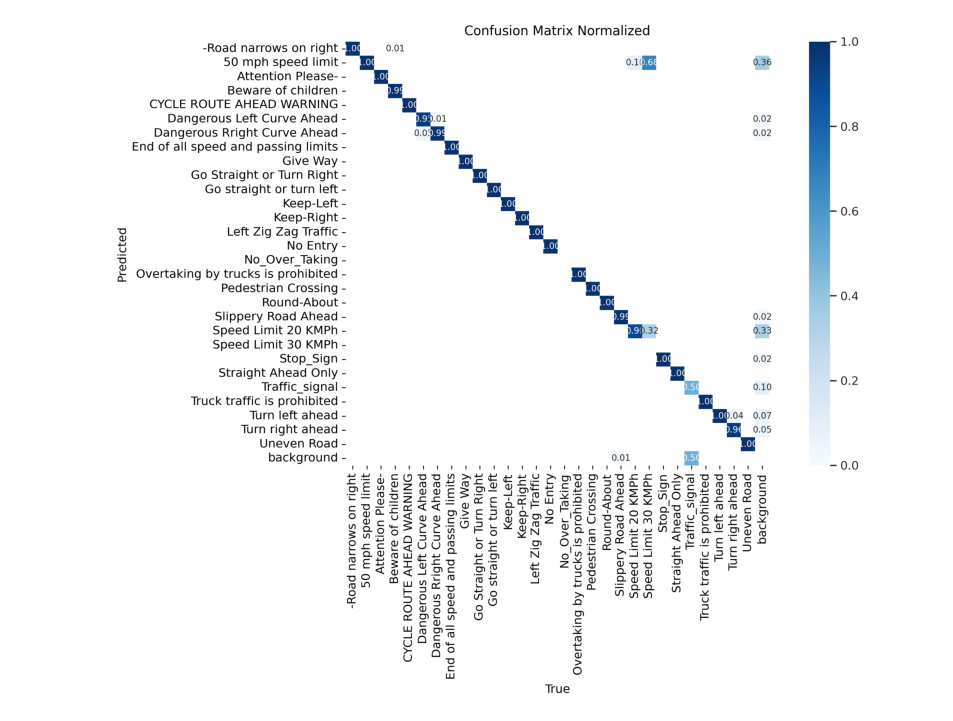

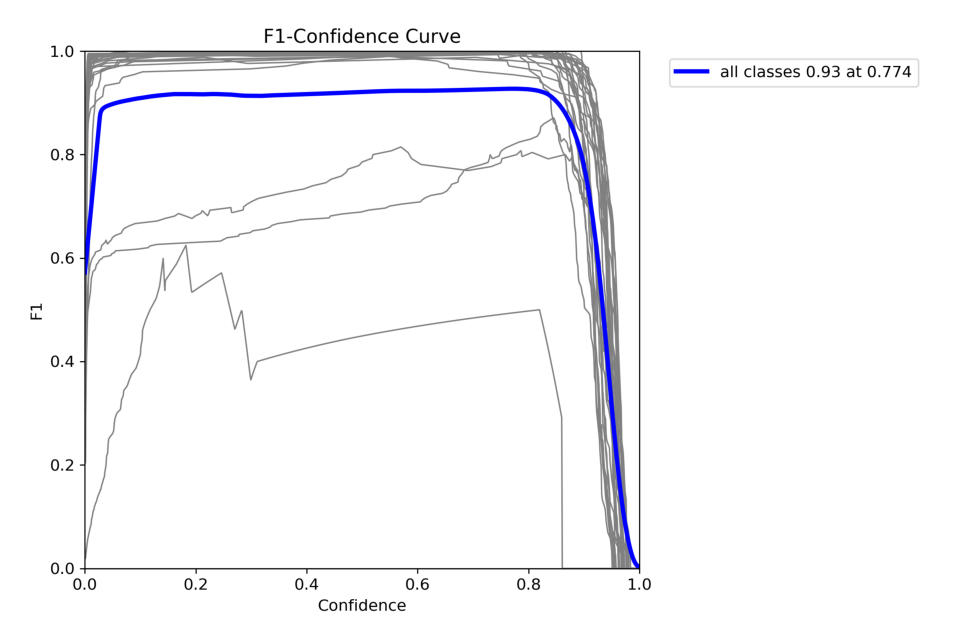

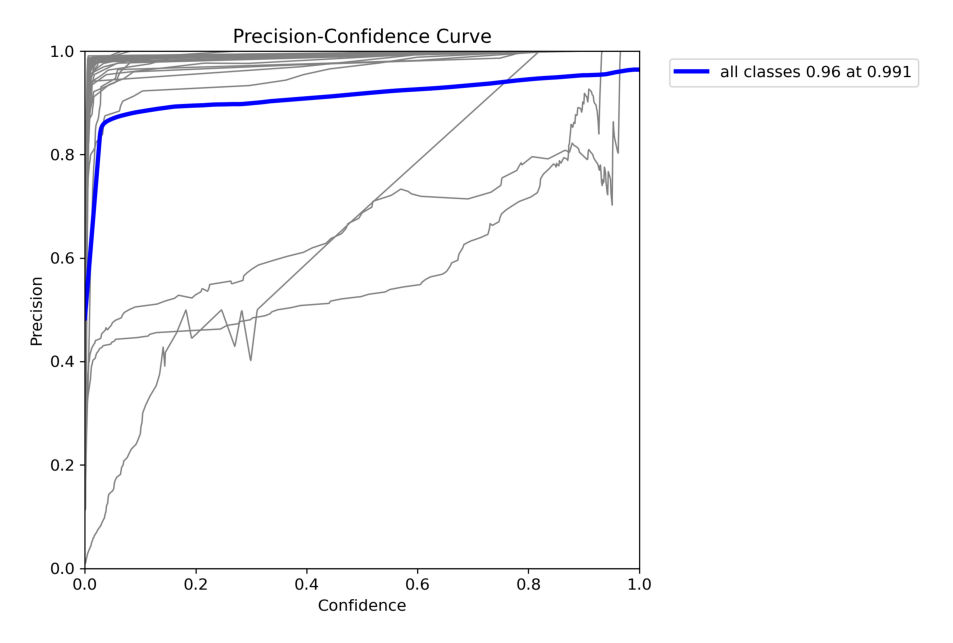

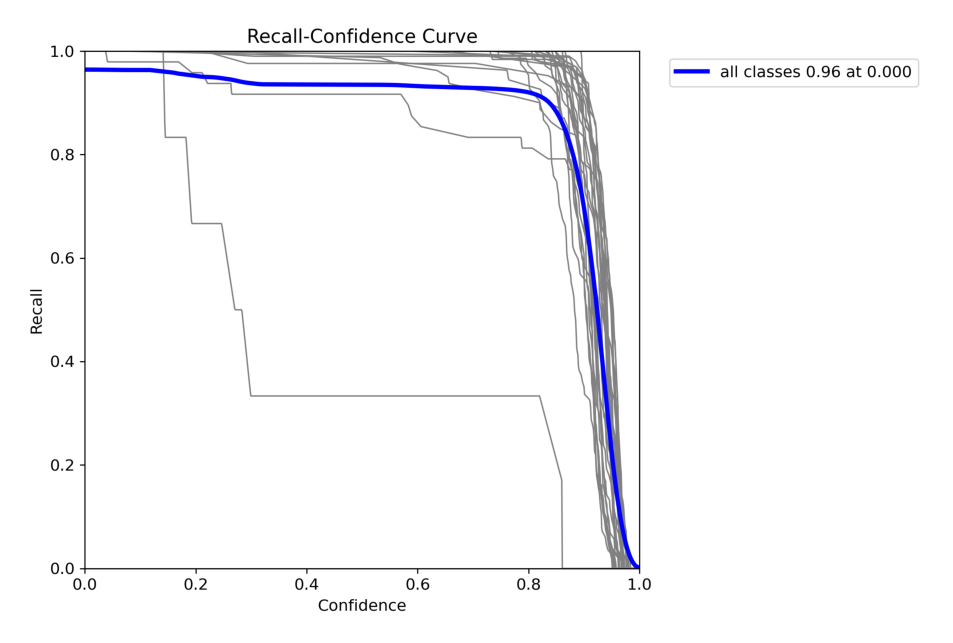

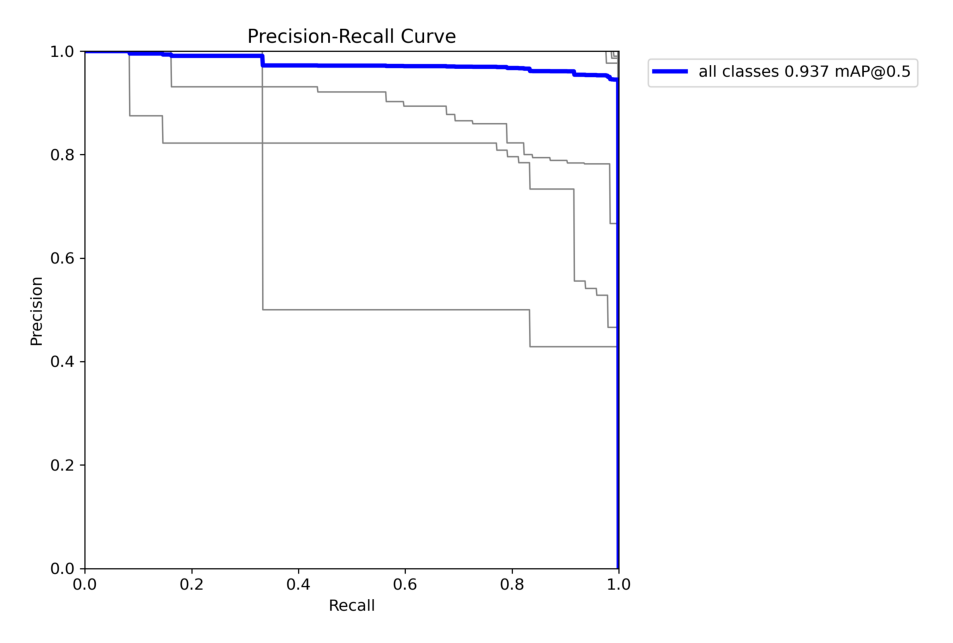

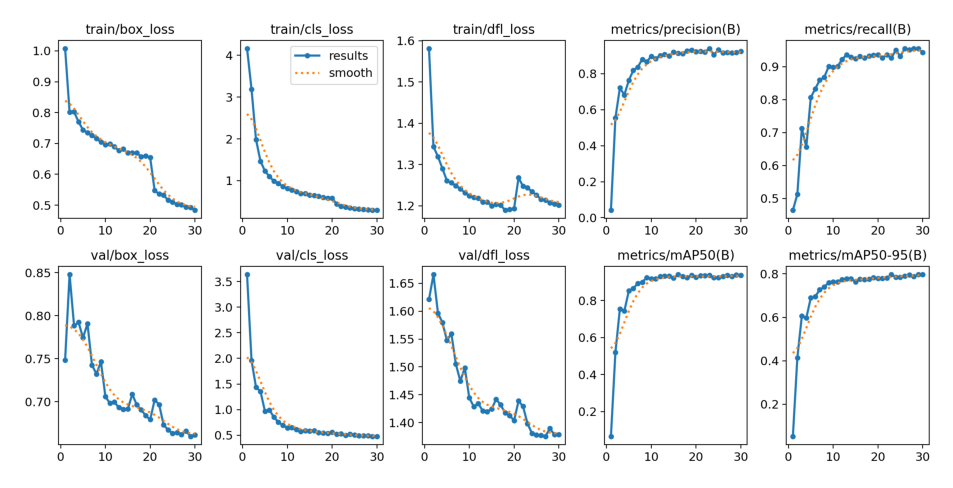

In [14]:
# Dynamically get the training directory
train_summary_path = get_latest_train_dir()
if train_summary_path:
    print(f"Using training directory: {train_summary_path}")
    display_images(train_summary_path)
else:
    print("No training directories found.")

#### Traffic Light Model
The second model that will be trained is the traffic light model. This model will use the Lisa dataset. Here we use the same strategy as before so we train for 30 epochs using the default optimizer and using the default batch size.

In [10]:
traffic_lights_model = YOLO('yolo11n.pt')
output_data_path = os.path.join(traffic_lights.location, "data.yaml")
results = traffic_lights_model.train(data=output_data_path, epochs = 30, batch = -1, optimizer = 'auto')

100%|██████████| 5.35M/5.35M [00:00<00:00, 183MB/s]


Ultralytics 8.3.58 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/working/LISA-traffic-light-detection-3/data.yaml, epochs=30, time=None, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, sh

100%|██████████| 755k/755k [00:00<00:00, 47.5MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /kaggle/working/LISA-traffic-light-detection-3/train/labels... 6251 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6251/6251 [00:05<00:00, 1186.63it/s]


train: New cache created: /kaggle/working/LISA-traffic-light-detection-3/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla P100-PCIE-16GB) 15.89G total, 0.12G reserved, 0.06G allocated, 15.71G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     2590425       6.443         0.371         46.18         137.1        (1, 3, 640, 640)                    list
     2590425       12.89         0.503         28.54          54.5        (2, 3, 640, 640)                    list
     2590425       25.77         0.904         37.37         109.3        (4, 3, 640, 640)                    list
     2590425       51.54         1.489         3

train: Scanning /kaggle/working/LISA-traffic-light-detection-3/train/labels.cache... 6251 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6251/6251 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/LISA-traffic-light-detection-3/valid/labels... 1784 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1784/1784 [00:01<00:00, 1520.85it/s]


val: New cache created: /kaggle/working/LISA-traffic-light-detection-3/valid/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.00071875), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30        13G      2.386       3.85      1.111        420        640: 100%|██████████| 68/68 [01:01<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


                   all       1784       5607    0.00429      0.322      0.204     0.0811

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      12.4G      1.781      1.876     0.9435        452        640: 100%|██████████| 68/68 [00:59<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:08<00:00,  1.25it/s]


                   all       1784       5607      0.874      0.262      0.504      0.243

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      12.4G      1.675      1.372     0.9279        432        640: 100%|██████████| 68/68 [00:59<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


                   all       1784       5607      0.652      0.543      0.576      0.205

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      12.6G      1.646      1.085     0.9252        412        640: 100%|██████████| 68/68 [00:59<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.28it/s]

                   all       1784       5607      0.762      0.627      0.704      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      12.8G      1.565     0.9348     0.9149        428        640: 100%|██████████| 68/68 [00:59<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]

                   all       1784       5607      0.797      0.711      0.754       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      12.7G       1.53     0.8652     0.9104        425        640: 100%|██████████| 68/68 [00:59<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]

                   all       1784       5607       0.83       0.68      0.767      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      12.6G      1.454     0.8041     0.8959        407        640: 100%|██████████| 68/68 [00:59<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.27it/s]

                   all       1784       5607      0.822      0.732      0.789       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      12.6G      1.406     0.7455     0.8887        420        640: 100%|██████████| 68/68 [00:59<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.28it/s]

                   all       1784       5607      0.886       0.77      0.835      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      12.7G      1.383     0.7264     0.8842        441        640: 100%|██████████| 68/68 [00:59<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.28it/s]

                   all       1784       5607      0.863      0.756      0.831      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      12.4G      1.336     0.6948     0.8788        384        640: 100%|██████████| 68/68 [00:59<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]

                   all       1784       5607      0.861       0.77      0.832      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      12.4G      1.335      0.682     0.8785        392        640: 100%|██████████| 68/68 [00:59<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]

                   all       1784       5607      0.883      0.793      0.861       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      12.6G      1.321      0.676     0.8741        457        640: 100%|██████████| 68/68 [00:59<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]

                   all       1784       5607       0.89      0.786      0.864      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      12.7G      1.298     0.6473     0.8722        386        640: 100%|██████████| 68/68 [00:59<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.27it/s]

                   all       1784       5607      0.907      0.804      0.876      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      12.7G      1.274     0.6404     0.8708        403        640: 100%|██████████| 68/68 [00:59<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]

                   all       1784       5607      0.916      0.817      0.886      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      12.4G      1.238      0.622     0.8703        438        640: 100%|██████████| 68/68 [00:59<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]

                   all       1784       5607      0.914      0.801      0.884      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      12.7G      1.243     0.6173     0.8646        426        640: 100%|██████████| 68/68 [00:59<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.25it/s]

                   all       1784       5607      0.913       0.82      0.883      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      12.7G      1.206     0.5971     0.8597        449        640: 100%|██████████| 68/68 [00:59<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.27it/s]

                   all       1784       5607      0.914      0.809      0.882      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      12.6G      1.189     0.5872     0.8602        420        640: 100%|██████████| 68/68 [00:59<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.28it/s]

                   all       1784       5607      0.915       0.81      0.886      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      12.7G      1.196     0.5841     0.8588        430        640: 100%|██████████| 68/68 [00:59<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]

                   all       1784       5607      0.932      0.831      0.897      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      12.4G      1.175     0.5735     0.8565        423        640: 100%|██████████| 68/68 [00:59<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.28it/s]

                   all       1784       5607      0.923      0.825        0.9      0.542


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      13.2G      1.143     0.5569     0.8636        275        640: 100%|██████████| 68/68 [01:02<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]

                   all       1784       5607      0.921      0.826      0.898      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      12.4G      1.121     0.5447     0.8587        298        640: 100%|██████████| 68/68 [00:58<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.27it/s]

                   all       1784       5607      0.913      0.841      0.907      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      12.4G        1.1     0.5279     0.8565        253        640: 100%|██████████| 68/68 [00:58<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]

                   all       1784       5607      0.927      0.836        0.9      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      12.4G      1.084     0.5189     0.8569        254        640: 100%|██████████| 68/68 [00:58<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]

                   all       1784       5607      0.928      0.841      0.908      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      12.5G      1.066     0.5086     0.8536        268        640: 100%|██████████| 68/68 [00:58<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]

                   all       1784       5607      0.913      0.857      0.912      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      12.4G      1.067     0.5042     0.8547        267        640: 100%|██████████| 68/68 [00:58<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.27it/s]

                   all       1784       5607      0.923      0.851      0.911      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      12.4G      1.032     0.4891      0.847        254        640: 100%|██████████| 68/68 [00:58<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.28it/s]

                   all       1784       5607      0.923      0.847      0.911      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      12.4G      1.021     0.4814     0.8435        274        640: 100%|██████████| 68/68 [00:58<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]

                   all       1784       5607      0.933      0.853      0.923      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      12.4G      1.007     0.4727     0.8454        283        640: 100%|██████████| 68/68 [00:58<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.28it/s]

                   all       1784       5607      0.929       0.86      0.921      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      12.4G     0.9942     0.4668     0.8452        274        640: 100%|██████████| 68/68 [00:58<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]

                   all       1784       5607      0.931       0.86      0.922      0.607



30 epochs completed in 0.573 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


                   all       1784       5607       0.93       0.86      0.922      0.607
                    go        921       2499      0.929       0.82      0.907      0.593
                  stop        815       2527      0.953      0.892      0.955      0.736
               warning        244        581      0.907      0.869      0.903      0.491
Speed: 0.1ms preprocess, 1.5ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train


In [11]:
traffic_lights_model.export(format='onnx')

Ultralytics 8.3.58 🚀 Python-3.10.12 torch-2.4.1+cu121 CPU (Intel Xeon 2.00GHz)
YOLO11n summary (fused): 238 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 7, 8400) (5.2 MB)
requirements: Ultralytics requirements ['onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.5/291.5 MB 247.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 251.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 300.7 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 12.0s, installed 2 packages: ['onnxslim', 'onnxruntime-gpu']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.47...
O

'runs/detect/train/weights/best.onnx'

### Validation of the Traffic Light Model
With the training phase complete, we can now visualize and analyze the results to evaluate the accuracy and performance of the YOLO model. These insights will help us better understand how well the model performs after training.

Using training directory: ./runs/detect/train


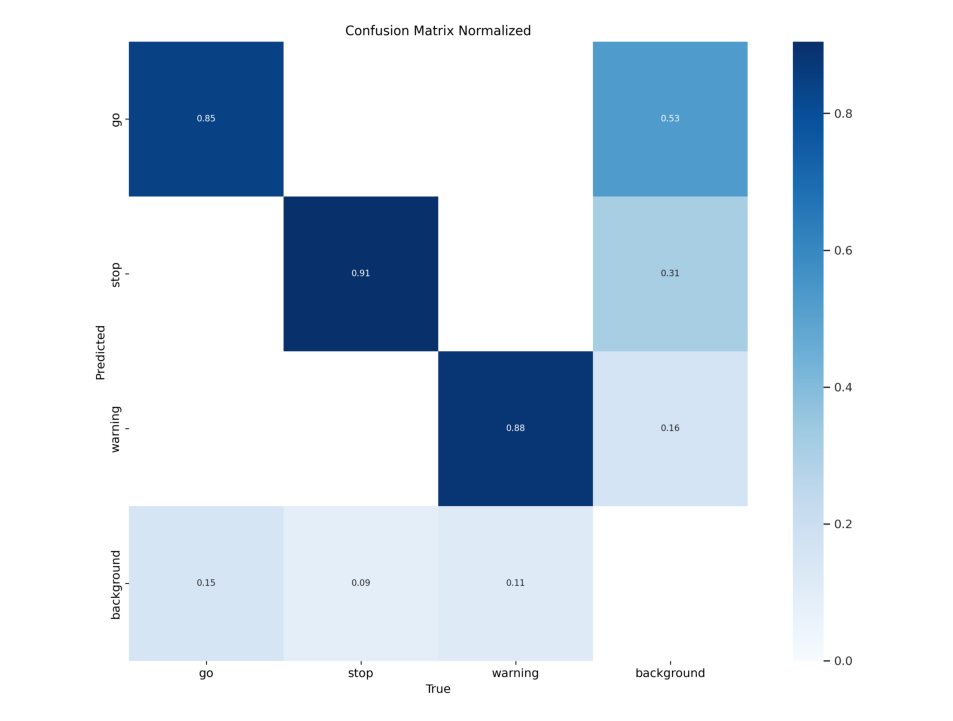

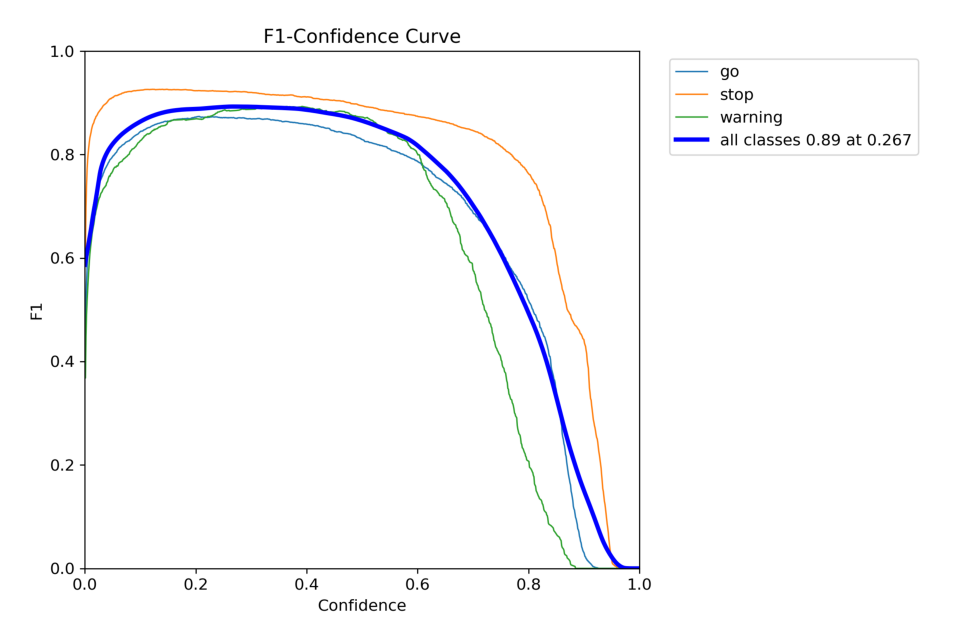

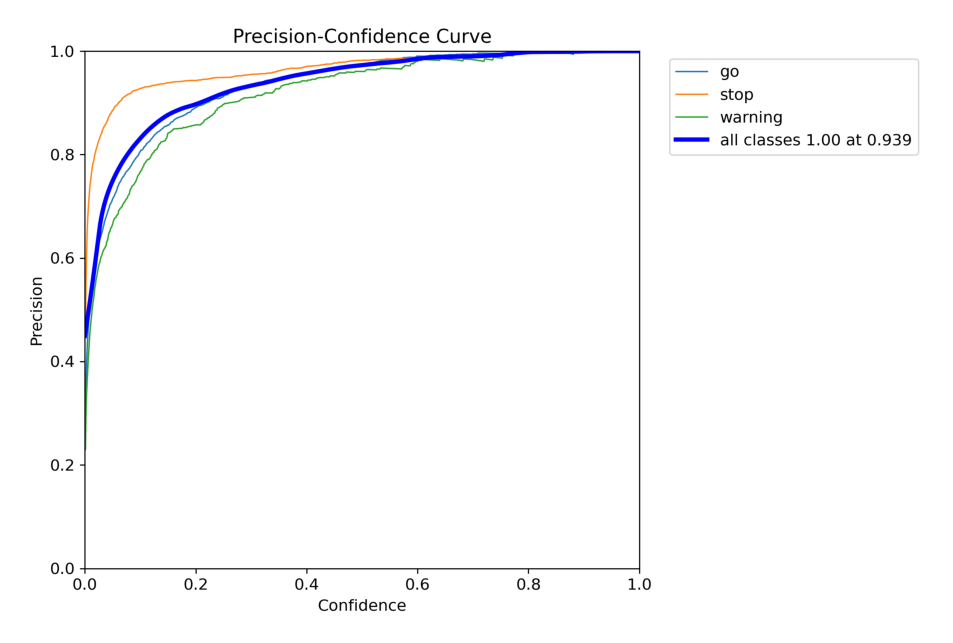

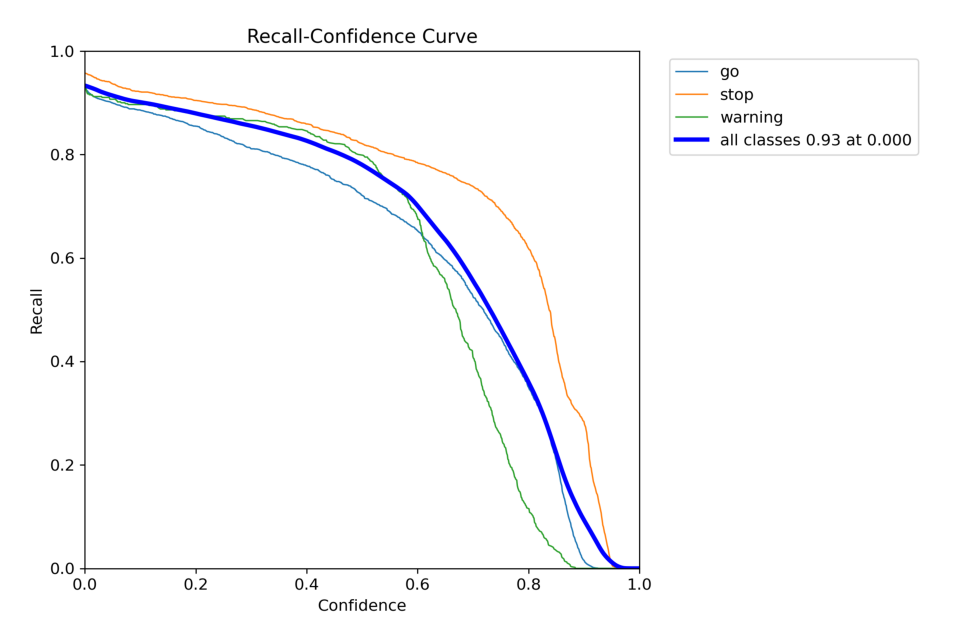

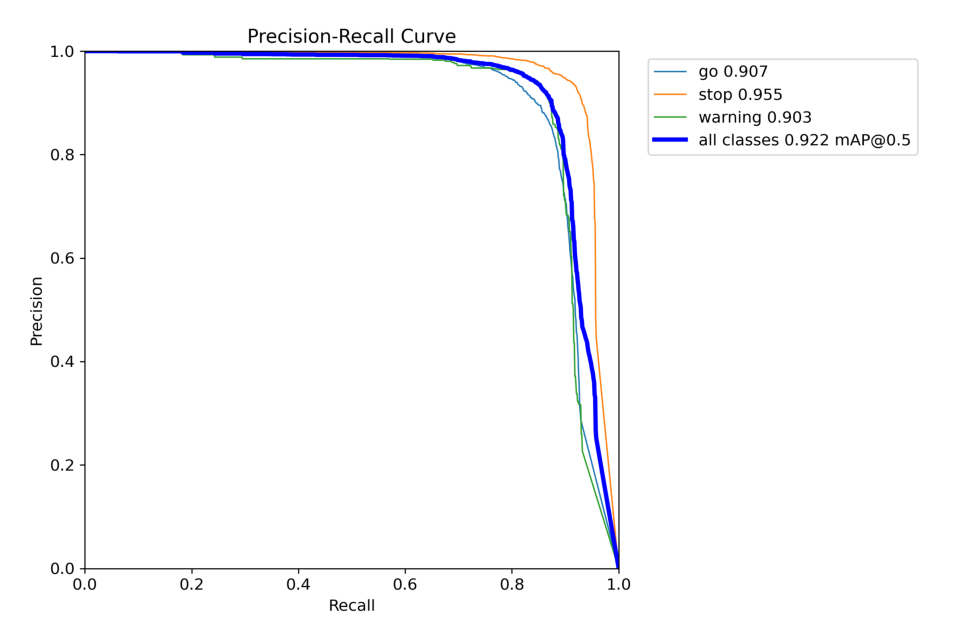

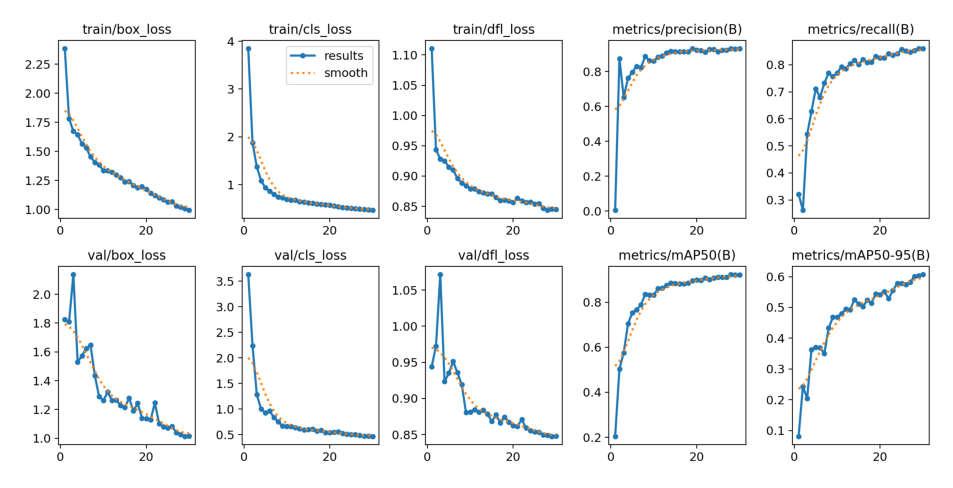

In [15]:
# Dynamically get the training directory
train_summary_path = get_latest_train_dir()
if train_summary_path:
    print(f"Using training directory: {train_summary_path}")
    display_images(train_summary_path)
else:
    print("No training directories found.")

#### Combination of the Models

Now that both models are trained, we need to combine them to process a single frame. This allows us to call both models for predictions on a given frame and return any detections to the caller.

---
#### Detectors Class
To achieve this, we created a class called `Detectors`. This class takes a list of models as input, in this example we pass as input the traffic sign model and the traffic light model. The class exposes a `detect` method that takes a single frame as input. Internally, it calls the `single_detect` method, which uses the provided model to identify objects belonging to Its trained classes.

The combined detections are returned as a list of objects. Each object includes the bounding box information (x1, y1, x2, y2) and the class name.

---

### Example Usage

```python

detector = Detectors([signs_model, lights_model])
detections = detector.detect(frame)

print(detections): detections = [[100, 50, 200, 150, 'Stop Sign'], [300, 100, 400, 200, 'stop']]

In [ ]:
class Detectors:
    """
    A class that combines multiple detection models (e.g., traffic signs and lights)
    to process a single frame and provide a consolidated list of detections.

    Attributes:
        models: All the models that will be used for executing the detection on the input frames.
    """

    def __init__(self, models: list):
        """
        Initializes the Detectors class with the specified models.

        Args:
            models: List of all the models used for the detection task.
        """
        self.models = list(models)

    def __single_detect(self, model, frame):
        """
        Uses the specified model to detect objects in the provided frame.

        Args:
            model: The detection model to use for predictions.
            frame: The image frame to analyze.

        Returns:
            A list of detected objects. Each object is represented as a list
            containing the bounding box coordinates (x1, y1, x2, y2) and
            the class name.
        """
        bbox_list = []
        objs = model.predict(frame, verbose=False, conf=0.5)[0].boxes.data.cpu().numpy()
        for det in objs:
            x1, y1, x2, y2, conf, cls = det
            bbox_list.append([x1, y1, x2, y2, model.names[cls]])
        return bbox_list

    def detect(self, frame):
        """
        Detects objects in the given frame using all the models stored inside this class.

        Args:
            frame: The image frame to analyze.

        Returns:
            A combined list of detections very models. Each detection
            includes bounding box coordinates and the class name.
        """
        detections = []
        for model in self.models:
          detections.extend(self.__single_detect(model, frame))
        return detections

detector = Detectors([traffic_sings_model, traffic_lights_model])

### Error handling
Set UTF-8 as encoding for possible errors

In [ ]:
import locale

def getpreferredencoding(do_setlocale: bool = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

### Object Traking Phase
#### Intersection over Union
Intersection over Union (IoU) is a metric used to evaluate the accuracy of object detection and tracking systems. It measures the overlap between two bounding boxes:

1. The predicted bounding box (what the model detects).
2. The ground truth bounding box (the actual or correct bounding box).

Mathematically, it is defined as:
$$ IoU = \frac{\text{Area of Overlap}}{\text{Area of Union}} $$
Where:

1. **Area of Overlap** is the region where the predicted and ground truth boxes intersect.
2. **Area of Union** is the total area covered by both bounding boxes combined, subtracting any overlap to avoid double-counting.

IoU serves as a quantitative measure of how well the predicted bounding box aligns with the ground truth. It ranges between 0 and 1:

1. IoU = 0 means no overlap between the boxes.
2. IoU = 1 means perfect overlap.

When tracking an object across frames, IoU helps in determining whether the object detected in the current frame corresponds to the same object detected in the previous frame.


In [ ]:
def compute_iou(bb1: list, bb2: list):
  bb1_x1=bb1[0]
  bb1_y1=bb1[1]
  bb1_x2=bb1[2]
  bb1_y2=bb1[3]

  bb2_x1=bb2[0]
  bb2_y1=bb2[1]
  bb2_x2=bb2[2]
  bb2_y2=bb2[3]

  x_left = max(bb1_x1, bb2_x1)
  y_top = max(bb1_y1, bb2_y1)
  x_right = min(bb1_x2, bb2_x2)
  y_bottom = min(bb1_y2, bb2_y2)

  if x_right < x_left or y_bottom < y_top:
    return 0.0

  intersection_area = (x_right - x_left) * (y_bottom - y_top)

  bb1_area = (bb1_x2 - bb1_x1) * (bb1_y2 - bb1_y1)
  bb2_area = (bb2_x2 - bb2_x1) * (bb2_y2 - bb2_y1)

  iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
  assert iou >= 0.0
  assert iou <= 1.0
  return iou

### Bounding Box tracker
The IOUTracker class is designed for simple object tracking in video or image sequences using Intersection-over-Union (IoU) as the basis for associating detected objects between frames. This tracker maintains a set of tracked objects and updates their positions based on new detections in each frame.

---

#### Initialization:
1. **\_\_init\_\_**(`iou_threshold`=0.5): Initializes the tracker with the following attributes:
iou_threshold: A float specifying the minimum IoU required to consider two bounding boxes as the same object (default is 0.5).
2. tracked_objects: A dictionary mapping object IDs to their bounding boxes.
next_object_id: An integer counter for assigning unique IDs to new objects.

#### Methods

1. `update(detections)`: Updates the set of tracked objects based on new detections.
  * **Parameters**: `detections`: A list of bounding boxes in the format [[x1, y1, x2, y2, class name], ...], where (x1, y1) is the top-left corner, and (x2, y2) is the bottom-right corner of the bounding box.

#### Process:
For each existing tracked object, it calculates the IoU with each detection.
Matches the detection with the highest IoU above the iou_threshold to the tracked object. Any unmatched detections are considered new objects and are assigned unique IDs. Returns:
* An updated dictionary of tracked objects (object_id -> bounding_box).

#### Key Features

* Tracks objects over multiple frames by associating new detections to existing tracked objects using IoU.
* Dynamically assigns new IDs to previously unseen objects.
* Provides a straightforward and efficient tracking mechanism, suitable for scenarios with moderate object movement and consistent detections.

---

### Example Usage

```python
tracker = IOUTracker(iou_threshold=0.5)
detections = [[100, 50, 200, 150, 'Stop Sign'], [300, 100, 400, 200, 'stop']]
tracked_objects = tracker.update(detections)
print(tracked_objects)


In [ ]:
class IOUTracker:
    """
    A tracker that uses Intersection Over Union (IOU) to match and track objects across frames.

    Attributes:
        iou_threshold (float): The minimum IOU required to consider a detection as the same object.
        tracked_objects (dict): A dictionary mapping object IDs to their bounding boxes.
        next_object_id (int): The next available ID for newly detected objects.
    """

    def __init__(self, iou_threshold=0.5):
        """
        Initializes the IOUTracker with a specified IOU threshold.

        Args:
            iou_threshold (float): The IOU threshold for associating detections with tracked objects.
        """
        self.iou_threshold = iou_threshold
        self.tracked_objects = {}  # Object ID -> Bounding Box
        self.next_object_id = 0

    def update(self, detections: list):
        """
        Updates the tracker with new detections and returns the currently tracked objects.

        Args:
            detections (list): A list of bounding boxes from the current frame.
                               Each bounding box is a list [x1, y1, x2, y2, class_name].

        Returns:
            dict: A dictionary of tracked objects where keys are object IDs and values are bounding boxes.
                  Each bounding box is in the format [x1, y1, x2, y2, class_name].
        """
        updated_tracked_objects = {}
        assigned_detections = set()

        # Match existing tracked objects to new detections
        for obj_id, prev_bbox in self.tracked_objects.items():
            best_iou = 0
            best_det_idx = -1

            for idx, det_bbox in enumerate(detections):
                if idx in assigned_detections:
                    continue
                iou = compute_iou(prev_bbox[:4], det_bbox[:4])
                if iou > best_iou and iou >= self.iou_threshold:
                    best_iou = iou
                    best_det_idx = idx

            if best_det_idx != -1:
                updated_tracked_objects[obj_id] = detections[best_det_idx]
                assigned_detections.add(best_det_idx)

        # Add new detections as new objects
        for idx, det_bbox in enumerate(detections):
            if idx not in assigned_detections:
                updated_tracked_objects[self.next_object_id] = det_bbox
                self.next_object_id += 1

        # Update the tracked objects
        self.tracked_objects = updated_tracked_objects
        return self.tracked_objects


#### Video Processing with Object Detection and Tracking

This function, `create_new_video`, processes a video to detect and track objects in each frame using YOLO-based detection and an IOU tracker. Here's how it works:

1. **Input and Output Initialization**:
   - The input video file is read using OpenCV, and its properties, such as frame rate, width, and height, are extracted.
   - The output video path is generated based on the input video name, and a `VideoWriter` is set up to save the processed frames.

2. **Object Detection**:
   - Each frame is read from the video, and YOLO-based object detection is performed using the `detector` class. The detected objects, including their bounding boxes and class names, are extracted.

3. **Object Tracking**:
   - The bounding boxes are passed to an IOU-based tracker that tracks objects across frames, maintaining consistent IDs for tracked objects.

4. **Frame Annotation**:
   - Tracked objects are drawn onto each frame. This includes:
     - Bounding boxes around detected objects.
     - Class names annotated near the bounding boxes.

5. **Output Video Generation**:
   - Each annotated frame is written to the output video file.
   - Once processing is complete, all resources are released, and the path to the output video is returned.

This function is useful for creating videos that visually display the results of object detection and tracking models, enabling easier analysis and visualization of model performance.


In [ ]:
def create_new_video(video_name: str):
    """
    Processes a video to detect and track objects, saving the results as a new video.

    Args:
        video_name (str): The name of the input video file.

    Returns:
        str: The file path of the processed output video.
    """
    # Construct input and output video paths
    input_path = os.path.join(traffic_lights_video_path, video_name)
    output_video_path = video_name.split('.')[0] + "-output.mp4"

    # Open the input video file
    cap = cv2.VideoCapture(input_path)

    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Set up the video writer for the output video
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

    # Initialize the tracker
    tracker = IOUTracker(iou_threshold=0.5)

    # Process each frame of the video
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Perform detection on the current frame
        results = detector.detect(frame)

        # Extract bounding boxes from the detections
        bbox_list = []
        for det in results:
            x1, y1, x2, y2, cls = det
            bbox_list.append([x1, y1, x2, y2, cls])

        # Update tracker with current frame's bounding boxes
        tracked_objects = tracker.update(bbox_list)

        # Draw tracked objects on the frame
        for obj_id, bbox in tracked_objects.items():
            x1, y1, x2, y2 = map(int, bbox[:4])
            class_name = bbox[4]
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, f'Class: {class_name}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 0), 2)

        # Write the processed frame to the output video
        out.write(frame)

    # Release resources
    cap.release()
    out.release()

    return output_video_path


### Test a video
Now that It was possible to train our system we can test the YOLO architecture on a video, by using the create\_new\_video function, then after parsing the video and checking If in each frame there is an possible object we create the output video that is possible to visualize by the following cell.

In [ ]:
  print(os.listdir(traffic_lights_video_path))
  video = create_new_video("traffic_lights_red_1.mp4")
  mp4 = open(video,'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

  HTML(""" <video controls><source src="%s" type="video/mp4"></video>""" % data_url)